# Train Transformer Decoder
This notebook trains the Transformer Decoder that will be used to generate text and embeds it in a GPT class. It is based on the [Neural Machine Translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer) tutorial by TensorFlow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_text as text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import config

## Dataset and tokenizer
Load dataset and tokenizer, see the tokenization notebook for details.

In [4]:
train_dataset = tf.data.Dataset.load(config.TRAIN_DATA_PATH)
val_dataset = tf.data.Dataset.load(config.VAL_DATA_PATH)
tokenizer = tf.saved_model.load(config.TOKENIZER_PATH)

## Make batches
Split the tokenized dataset into input and target sequences, split into batches for model training.

In [5]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text


def make_batches(ds):
    return (
        ds.map(split_input_target, tf.data.AUTOTUNE)
        .batch(config.BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [6]:
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

## Decoder
Compile and train the Transformer Decoder model.

In [7]:
from model import Decoder, masked_loss, masked_accuracy, CustomSchedule

decoder = Decoder(
    num_layers=config.N_LAYERS,
    d_model=config.D_MODEL,
    num_heads=config.N_HEADS,
    dff=config.FFN_DIM,
    vocab_size=config.VOCAB_SIZE,
    dropout_rate=config.DROPOUT_RATE,
)

In [8]:
# Build the transformer by applying it to a sample
for input_text, target_text in train_batches.take(1):
    break
decoder(input_text)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posi  multiple                  48000     
 tionalEmbedding)                                                
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 decoder_layer (DecoderLaye  multiple                  872       
 r)                                                              
                                                                 
 layer_normalization_2 (Lay  multiple                  16        
 erNormalization)                                                
                                                                 
 dense_2 (Dense)             multiple                  54000     
                                                           

In [9]:
from model import CustomSchedule

learning_rate = CustomSchedule(config.D_MODEL)
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate, **config.OPTIMIZER_KWARGS
)

Text(0.5, 0, 'Train Step')

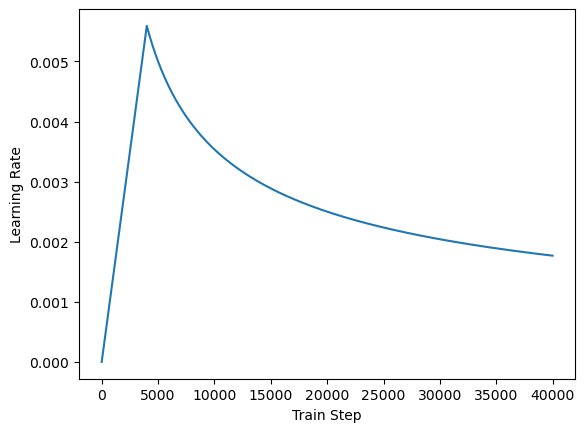

In [10]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [11]:
from model import masked_loss, masked_accuracy

decoder.compile(
    loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy]
)

In [12]:
decoder.fit(train_batches, epochs=config.N_EPOCHS, validation_data=val_batches)

4500/4500 [==============================] - 143s 32ms/step - loss: 5.8624 - masked_accuracy: 0.1049 - val_loss: 5.2668 - val_masked_accuracy: 0.1378


## GPT
Use the Decoder model and tokenizer in a GPT.

In [13]:
output_length = 100

In [14]:
input = "king lear:"
tokens = tokenizer.tokenize([input]).to_tensor()
output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
output_array = output_array.unstack(tokens[0])

i = tokens.shape[1]

In [15]:
tokens

<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[ 86, 532,  12]])>

In [47]:
output_tensor = tf.expand_dims(output_array.stack(), axis=0)
predictions = decoder(output_tensor, training=False)[:, -1:, :]
probabilities = tf.keras.activations.softmax(predictions, axis=-1)
logits = tf.math.log(probabilities)[0]
predicted_token = tf.random.categorical(logits, num_samples=1)[0, 0]
predicted_token

<tf.Tensor: shape=(), dtype=int64, numpy=70>

In [33]:
for _ in range(output_length):
    output_tensor = tf.expand_dims(output_array.stack(), axis=0)

    # Select the last predicted token from the `seq_len` dimension.
    predictions = decoder(output_tensor, training=False)[
        :, -1:, :
    ]  # Shape `(batch_size, 1, vocab_size)`.
    predicted_token = tf.argmax(predictions, axis=-1)[0, 0]
    output_array = output_array.write(i, predicted_token)
    i += 1

In [ ]:
predicted_tokens = tf.expand_dims(output_array.stack(), axis=0)
generated_text = (
    tokenizer.detokenize(predicted_tokens).numpy()[0].decode("utf-8")
)
print(generated_text)

In [ ]:
print(
    "king lear : what , are you mad ? fool : no , no , no ; i ' ll be sworn . fool : why , i ' ll be sworn , sir , i ' ll be sworn . fool : why , i ' ll be sworn i am a fool . fool : why , then , nuncle , i ' ll be sworn i am a fool . fool : why , then , nuncle , i ' ll be sworn i ' ll be sworn i am a fool . fool : why , fool , i"
)

In [ ]:
class GPT(tf.Module):
    """"""

    def __init__(self, tokenizer, decoder: tf.keras.Model, output_length: int):
        self.tokenizer = tokenizer
        self.decoder = decoder
        self.output_length = output_length

    @tf.function
    def __call__(self, prompt: str) -> str:
        """"""
        tokens = self.tokenizer.tokenize([prompt]).to_tensor()
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.unstack(tokens[0])
        i = tf.shape(tokens)[1]

        for _ in range(self.output_length):
            output_tensor = tf.expand_dims(output_array.stack(), axis=0)

            # Select the last predicted token from the `seq_len` dimension.
            predictions = self.decoder(output_tensor, training=False)[
                :, -1:, :
            ]  # Shape `(batch_size, 1, vocab_size)`.
            predicted_token = tf.argmax(predictions, axis=-1)[0, 0]
            output_array = output_array.write(i, predicted_token)
            i += 1

        predicted_tokens = tf.expand_dims(output_array.stack(), axis=0)
        generated_text = self.tokenizer.detokenize(predicted_tokens)
        return generated_text[0]

In [ ]:
tf.saved_model.save(gpt, export_dir=config.GPT_PATH)